## Phase 4.41 - 4.42

# Tensorflow, Deep Neural Networks

## Objectives
- Get some <a href='#background'>background</a> in Tensorflow, Keras (and PyTorch).
- Look at <a href='#tensors'>Tensors</a> and how they're used.
- Start working in <a href='#tensorflow'>Tensorflow</a>!
    - <a href='#preprocessing'>Processing Data</a>.
    - Various methods of <a href='#tuning'>building and tuning a Model</a>.

# Tensorflow / Keras
<a id='background'></a>
## Background

- Keras is an API coded in Python.
- There are three systems built on the Keras API: *Tensorflow*, *Theano*, *CNTK*.
    - *Theano has been discontinued. The last release was 2017, but can still be used.*
- Keras development is backed primarily by Google, and the Keras API comes packaged in TensorFlow as tf.keras.
- **We will use TensorFlow**, as it is the most popular. TensorFlow became the most used Keras backend, and eventually integrated Keras into via the tf.keras submodule of TensorFlow.


> *PyTorch is the leading competitor to Tensorflow based on interest and usage.*
>
> *Many higher education institutions are teaching deep learning via PyTorch. Although not at all necessary to know both, I would recommend to keep PyTorch in your mind and perhaps add to your repertoire as a Data Scientist.*

<a id='tensors'></a>
# Tensors
<img src='./images/tensors.png' width=600>

> **Left:** A "Column"
>
> **Middle:** A "DataFrame"
>
> **Right:** A "multi-dimensional DataFrame". *Most commonly images.*

## Tensors as *Images*

- A Black and White image can be represented as a tensor of shape *$\large (m, n)$* where coordinate $\large (m_i, n_i)$ points to a *pixel*.
<img src='./images/bw_pixel.jpeg' width=300>

- A Color image (rgb) can be represented as a tensor of shape *$\large (m, n, 3)$* where a coordinate $\large (m_i, n_i, r)$ would point to a pixel in layer $\large r$ and $\large (m_i, n_i, b)$ would point to a pixel in layer $\large b$.
<img src='./images/rgb_example.png'>

## Tensors as *Game-States*

> - **AlphaZero**, Google's Reinforcement Learning Neural Network was trained to play games (Go, Chess, Shogi, Starcraft II, others). 
> - This is a two-part model:
    1. A Neural Network and 
    2. a Monte Carlo Tree Search algorithm.
    
    
- 3-dimensional tensors are used as an input and output for the neural network.


- Input is a tensor of shape *$\large (N, N, (MT + L))$*.
    - $N x N$ represents the shape of the board.
        - (8, 8) for chess: *[1-8, a-h]*.
    - $T$ represents a *time-step* for the game.
        - The previous 8-game positions are stored and fed as an input.
    - $M$ represents a binary representation of the presence of the player's pieces on the board, one for each piece-type.
        - 6 piece-types for chess: Pawn, Knight, Bishop, Rook, Queen, King
    - $L$ represents a number of constant-vaues input plantes, denoting aspects of the game-state.
        - Player's color, total move count, special rules (castling, repetition count for that specific position, number of moves "without progress").

<img src='./images/alphazero_input.png' width=500>

#### Fun Facts:
> Match Results: Google's Deep Mind project **AlphaZero** vs reigning WCCC Champion **Stockfish**.
>
> | Game | White | Black | Win | Draw | Loss |
> | ---- | ----- | ----- | --- | ---- | ---- |
> | Chess | AlphaZero | Stockfish | 25 | 25 | 0
> | Chess | Stockfish | AlphaZero | 3 | 47 | 0
>
> - *Stockfish "calculates" 60, 000, 000 positions per second. AlphaZero "calculates" 60, 000 positions per second.*
> - *AlphaZero was trained on 9-hours of training ("self-play").*
>
> Additional Resources and Information:
> <a href='https://arxiv.org/abs/1712.01815'>Mastering Chess and Shogi [...]</a>

<a id='tensorflow'></a>
# Working with Tensorflow

**In this example, we want to be using *DataFrame-shaped* Tensors** $(m, n)$.
*In order to do this, we will want **each row to represent an entire image** and each column to represent a pixel.*

*We will talk about CNNs next - where each row is an entire image, but is **not** flattened first.* 
- E.g.: An input could be represented in shape $(1000, 64, 64, 3)$.*
```
DataShape = (
    {number of images = 1000}, 
    {number of rows (pixels) = 64}, 
    {number of columns (pixels) = 64}, 
    {number of planes (rgb) = 3}
)
```

## Loading Data

In [1]:
import keras
import tensorflow as tf
from tensorflow.keras import layers, Sequential

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
X = digits.images
y = digits.target

In [4]:
X.shape

(1797, 8, 8)

In [5]:
y.shape

(1797,)

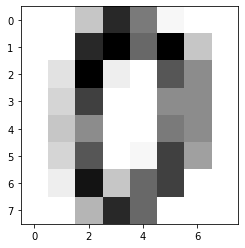

In [6]:
plt.imshow(X[0], cmap='Greys');

In [7]:
# Also, we could access "flat" images directly from this dataset, as seen before.
digits['data'][0].shape

(64,)

In [8]:
digits['data'][0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

<a id='preprocessing'></a>
## Preprocessing
*Not strictly necessary with this toy dataset since the images can be accessed as "flat" already, however we can get a sense of what the preprocessing will be like in Tensorflow.*

- Flatten each image into a row of data.
    - Alternatively, with this example, we could just use `data`.
- Train-test-split into Train, Test, Validation
    - Sizes: (0.7, 0.15, 0.15)
- Scale data to a value [0-1] (pixel intensity)


- One Hot Encode our target.

### Flattening Images

In [9]:
X[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [14]:
y[0]

0

In [10]:
# Already a numpy array.
X[0].reshape(-1,)

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [11]:
X_flat = X.reshape(X.shape[0], -1)
X_flat.shape

(1797, 64)

In [13]:
X_flat[:5]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
        15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
        12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
         0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
        10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.,  0.,  0.,  0., 11., 16.,
         9.,  0.,  0.,  0.,  0.,  3., 15., 16.,  6.,  0.,  0.,  0.,  7.,
        15., 16., 16.,  2.,  0.,  0.,  0.,  0.,  1., 16., 16.,  3.,  0.,
         0.,  0.,  0.,  1., 16., 16.,  6.,  0.,  0.,  0.,  0.,  1., 16.,
        16.,  6.,  0.,  0.,  0.,  0.,  0., 11., 16., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  4., 15., 12.,  0.,  0.,  0.,  0.,  3., 16., 15.,
        14.,  0.,  0.,  0.,  0.,  8., 13.,  8., 16.,  0.,  0.,  0.,  0.,
         1.,  6., 15., 11.,  0.,  0.,  0.,  1.,  8., 13., 15.,  1.,  0.,
         0.,  0.,  9., 16., 16.,  5.,  0.,  0.,  0.,  0.,  

In [ ]:
# # Alternate method without using the broadcasting `.reshape`.
# X_flat = np.array([x.reshape(-1,) for x in X])

In [12]:
# Sanity Check
all(digits['data'][0] == X_flat[0])

True

### Target Processing: OneHotEncoder

- Differently from scikit-learn models, Tensorflow multiclass classification models' predictions are an array (a OneHotEncoded version of a multiclass variable).
- Since we are encoding only our target (and we want this representation consistent) we can perform this before the train-test-split.

In [15]:
ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(y.reshape(-1, 1))

In [16]:
y_ohe.shape

(1797, 10)

In [17]:
ohe.categories_

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]

In [18]:
y_ohe[:5]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

### Train Test Split
*My go-to train/test/val size is (0.7, 0.15, 0.15), but there is no hard and fast rule on this.*

In [19]:
SEED = 51
TEST_SIZE = int(X_flat.shape[0] * 0.15)

# Number of samples for Test and Val
TEST_SIZE

269

In [20]:
# Split out Test data first.
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_ohe, test_size=TEST_SIZE, random_state=SEED)

# Split Val from training data.
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=TEST_SIZE, random_state=SEED)

# Sanity check.
print(f'Train:\n\tX: {X_train.shape}\n\ty: {y_train.shape}')
print(f'Test:\n\tX: {X_test.shape}\n\ty: {y_test.shape}')
print(f'Val:\n\tX: {X_val.shape}\n\ty: {y_val.shape}')

Train:
	X: (1259, 64)
	y: (1259, 10)
Test:
	X: (269, 64)
	y: (269, 10)
Val:
	X: (269, 64)
	y: (269, 10)


### Scaling Data

In [21]:
# Check the max values in each image array.
(max([x for img in X_train for x in img]),
 max([x for img in X_test for x in img]),
 max([x for img in X_val for x in img]))

(16.0, 16.0, 16.0)

*Since pixel data exists with constraints (255 is the maximum value for most images, 16 is the maximum value here), there is no worry of data leakage between data sets.*

In [22]:
# Scaling data.
X_train, X_test, X_val = X_train / 16, X_test / 16, X_val / 16

In [23]:
# Sanity check.
(max([x for img in X_train for x in img]),
 max([x for img in X_test for x in img]),
 max([x for img in X_val for x in img]))

(1.0, 1.0, 1.0)

## Building a Model

- FFNN (Forward-Feed Neural Networks) are named for the way they proceed sequentially through their layers.
- For today, we will only look at this model type.
- In Tensorflow they are part of a class `Sequential`.

In [24]:
# Starting model construction.
model = Sequential()
model

In [25]:
X_train.shape[1]

64

In [26]:
# Adding an input layer.
model.add(
    layers.Dense(units=4, activation='relu', input_dim=X_train.shape[1])
    )

In [27]:
# Adding an output layer.
model.add(
    layers.Dense(units=10, activation='softmax')
    )

- Lastly, we have to define a loss function, a metric, and an optimizer.

- Optimizers are functions which update our weights in smart ways instead of treating all parameters equaly. Adam, a popular optimizer, calculates an individual learning rate for each parameter.

In [28]:
# Compile model with an optimizer, loss function, and preferred metrics.
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
    )

In [29]:
# Show model summary.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 260       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                50        
Total params: 310
Trainable params: 310
Non-trainable params: 0
_________________________________________________________________


## Fitting / Predicting

In [30]:
# Fit
model.fit(X_train, y_train)

40/40 [==============================] - 0s 642us/step - loss: 2.2923 - accuracy: 0.1487


In [31]:
# Predict
model.predict(X_test[[0]])

array([[0.05192965, 0.16121136, 0.15470801, 0.06930816, 0.05876956,
        0.06789389, 0.08977865, 0.11768293, 0.11316589, 0.11555183]],
      dtype=float32)

In [32]:
# Predict class
np.argmax(model.predict(X_test[[0]]), axis=-1)

array([1])

In [33]:
predictions_df = pd.DataFrame(
    zip(ohe.categories_[0], model.predict(X_test[[0]])[0]),
    columns=['Target', 'Softmax']
    )
predictions_df

,Target,Softmax
0,0,0.051930
1,1,0.161211
2,2,0.154708
3,3,0.069308
4,4,0.058770
5,5,0.067894
6,6,0.089779
7,7,0.117683
8,8,0.113166
9,9,0.115552


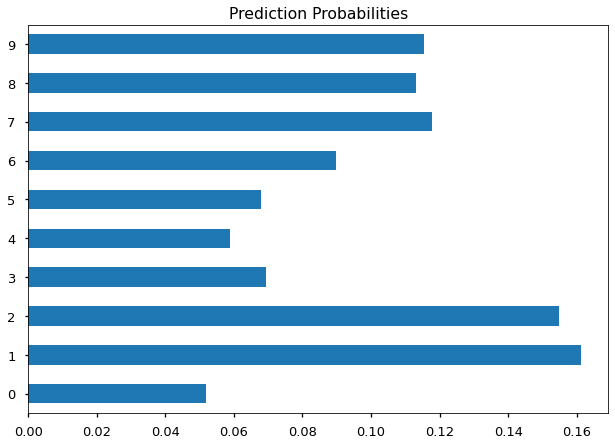

In [34]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots()
    predictions_df['Softmax'].plot(kind='barh')
    ax.set(title='Prediction Probabilities')

In [35]:
# Functionalizing the above.
def plot_prediction_probabilities(trained_model, encoder, entry):
    """
    Show a bar chart representing prediction probabilities.
    """
    
    predictions_df = pd.DataFrame(
        zip(encoder.categories_[0], trained_model.predict(entry)[0]),
        columns=['Target', 'Softmax']
        )
    with plt.style.context('seaborn-talk'):
        fig, ax = plt.subplots()
        predictions_df['Softmax'].plot(kind='barh')
        ax.set(title='Prediction Probabilities')
        plt.show()

## Incorporating Validation Data

In [36]:
# Add validation data.
model.fit(X_train, y_train, validation_data=(X_val, y_val))

40/40 [==============================] - 1s 18ms/step - loss: 2.1882 - accuracy: 0.2438 - val_loss: 2.1425 - val_accuracy: 0.2825


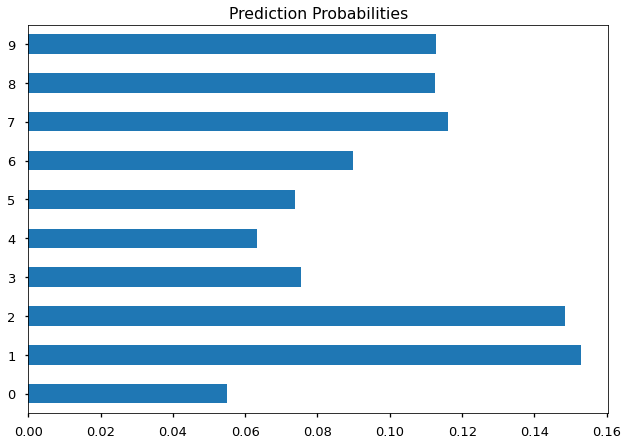

In [37]:
plot_prediction_probabilities(model, ohe, X_test[[0]])

## Add Epochs

In [38]:
# Save the model fit to a variable. Training info is stored here.
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)

Epoch 1/5
40/40 [==============================] - 0s 3ms/step - loss: 2.1309 - accuracy: 0.2859 - val_loss: 2.0771 - val_accuracy: 0.2937
Epoch 2/5
40/40 [==============================] - 0s 2ms/step - loss: 2.0597 - accuracy: 0.3106 - val_loss: 1.9842 - val_accuracy: 0.3680
Epoch 3/5
40/40 [==============================] - 0s 2ms/step - loss: 1.9620 - accuracy: 0.3542 - val_loss: 1.8707 - val_accuracy: 0.4201
Epoch 4/5
40/40 [==============================] - 0s 4ms/step - loss: 1.8626 - accuracy: 0.3844 - val_loss: 1.7755 - val_accuracy: 0.4387
Epoch 5/5
40/40 [==============================] - 0s 2ms/step - loss: 1.7753 - accuracy: 0.3971 - val_loss: 1.6915 - val_accuracy: 0.4461


In [39]:
history

In [40]:
history.history

{'loss': [2.130906581878662,
  2.059697151184082,
  1.961951732635498,
  1.8625849485397339,
  1.7752835750579834],
 'accuracy': [0.2859412133693695,
  0.31056395173072815,
  0.35424941778182983,
  0.3844320774078369,
  0.39714059233665466],
 'val_loss': [2.07707142829895,
  1.9842084646224976,
  1.8707329034805298,
  1.7754820585250854,
  1.6915297508239746],
 'val_accuracy': [0.2936803102493286,
  0.36802974343299866,
  0.42007434368133545,
  0.43866172432899475,
  0.44609665870666504]}

In [41]:
def plot_history(history, style=['ggplot', 'seaborn-talk']):
    """
    Plot history from History object (or history dict) 
    once Tensorflow model is trained.
    
    Parameters:
    -----------
    history:
        History object returned from a model.fit()
    style: string or list of strings (default: ['ggplot', 'seaborn-talk'])
        Style from matplotlib.
    """
    
    # We can pass in a model history object or a dictionary.
    if not isinstance(history, dict): # We prefer this type of check over `if type() == ...`
        history = history.history

    metrics_lst = [m for m in history.keys() if not m.startswith('val')]
    N = len(metrics_lst)
    with plt.style.context(style):
        fig, ax_lst = plt.subplots(nrows=N, figsize=(8, 4*(N)))
        ax_lst = [ax_lst] if N == 1 else ax_lst.flatten() # Flatten ax_lst.
        for metric, ax in zip(metrics_lst, ax_lst):
            val_m = f'val_{metric}'
            ax.plot(history[metric], label=metric)
            ax.plot(history[val_m], label=val_m)
            ax.set(title=metric.title(), xlabel='Epoch', ylabel=metric.title())
            ax.legend()
        fig.tight_layout()
        plt.show()

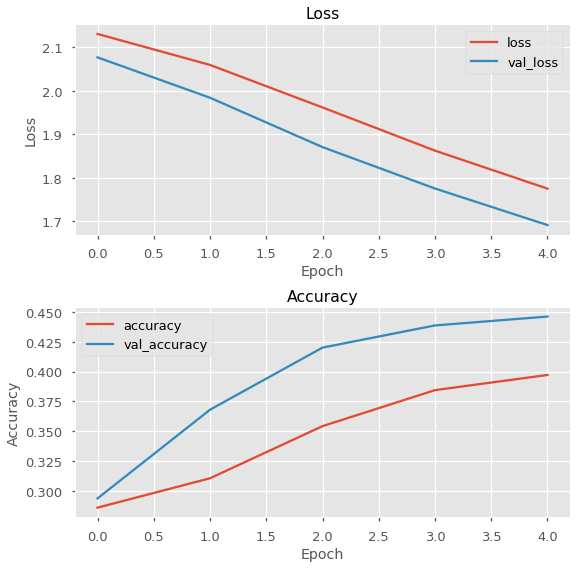

In [42]:
plot_history(history)

In [43]:
# Adding more epochs!
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
40/40 [==============================] - 0s 3ms/step - loss: 1.6943 - accuracy: 0.4162 - val_loss: 1.6146 - val_accuracy: 0.4647
Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 1.6198 - accuracy: 0.4575 - val_loss: 1.5450 - val_accuracy: 0.4944
Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 1.5487 - accuracy: 0.5052 - val_loss: 1.4796 - val_accuracy: 0.5316
Epoch 4/10
40/40 [==============================] - 0s 2ms/step - loss: 1.4819 - accuracy: 0.5210 - val_loss: 1.4181 - val_accuracy: 0.5688
Epoch 5/10
40/40 [==============================] - 0s 2ms/step - loss: 1.4226 - accuracy: 0.5528 - val_loss: 1.3635 - val_accuracy: 0.5836
Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 1.3664 - accuracy: 0.5941 - val_loss: 1.3133 - val_accuracy: 0.6171
Epoch 7/10
40/40 [==============================] - 0s 2ms/step - loss: 1.3139 - accuracy: 0.6140 - val_loss: 1.2642 - val_accuracy: 0.6580
Epoch 8/10
40/40 [==

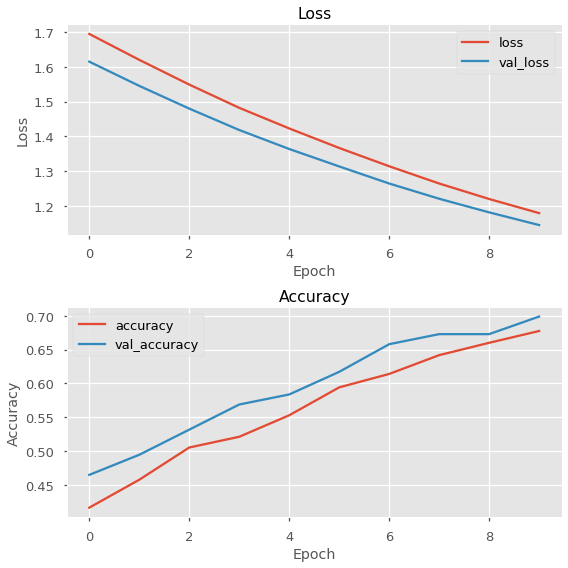

In [44]:
plot_history(history)

## Add Layers
There are no hard set rules for building neural networks. It is an empirical process, where one tries different architectures and see what works. However, it is a good idea to try out deep networks, since we know that successive layers find increasingly complex patterns.

In [45]:
# Building a new model with a hidden layer.
model = Sequential()
model.add(layers.Dense(units=4, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dense(units=6, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))

model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4)                 260       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 30        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                70        
Total params: 360
Trainable params: 360
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
40/40 [==============================] - 1s 5ms/step - loss: 2.3101 - accuracy: 0.0952 - val_loss: 2.2749 - val_accuracy: 0.0743
Epoch 2/20
40/40 [==============================] - 0s 2ms/step - loss: 2.2643 - accuracy: 0.0879 - val_loss: 2.2311 - val_accuracy: 0.0818
Epoch 3/20
40/40 [==============================] - 0s 2ms/step - loss: 2.2233 - accuracy: 0.1173 - val_loss: 2.1847 - val_accuracy: 0.1375
Epoch 4/20
40/40 [==============================] - 0s 2ms/step - loss: 2.1763 - accuracy: 0.1941 - val_loss: 2.1304 - val_accuracy: 0.1933
Epoch 5/20
40/40 [==============================] - 0s 2ms/step - loss: 2.1122 - accuracy: 0.2331 - val_loss: 2.0743 - val_accuracy: 0.1970
Epoch 6/20
40/40 [==============================] - 0s 2ms/step - loss: 2.0841 - accuracy: 0.2144 - val_loss: 2.0188 - val_accuracy: 0.2602
Epoch 7/20
40/40 [==============================] - 0s 2ms/step - loss: 2.0112 - accuracy: 0.2783 - val_loss: 1.9640 - val_accuracy: 0.2974
Epoch 8/20
40/40 [==

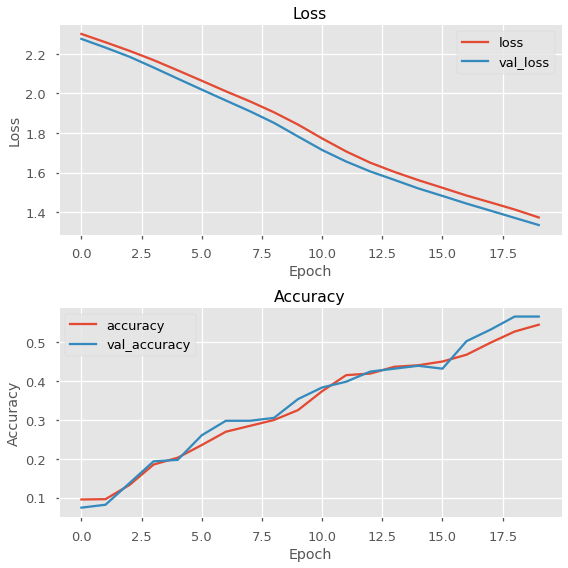

In [47]:
plot_history(history)

In [48]:
# Adding one more layer.
model = Sequential()
model.add(layers.Dense(units=4, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dense(units=6, activation='relu'))
model.add(layers.Dense(units=10, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4)                 260       
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 30        
_________________________________________________________________
dense_7 (Dense)              (None, 10)                70        
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
Total params: 470
Trainable params: 470
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
40/40 [==============================] - 1s 5ms/step - loss: 2.2884 - accuracy: 0.1699 - val_loss: 2.2588 - val_accuracy: 0.2454
Epoch 2/20
40/40 [==============================] - 0s 2ms/step - loss: 2.2547 - accuracy: 0.2076 - val_loss: 2.2058 - val_accuracy: 0.2454
Epoch 3/20
40/40 [==============================] - 0s 2ms/step - loss: 2.1920 - accuracy: 0.2068 - val_loss: 2.1106 - val_accuracy: 0.2007
Epoch 4/20
40/40 [==============================] - 0s 2ms/step - loss: 2.0747 - accuracy: 0.1857 - val_loss: 1.9924 - val_accuracy: 0.2230
Epoch 5/20
40/40 [==============================] - 0s 2ms/step - loss: 1.9228 - accuracy: 0.2660 - val_loss: 1.8897 - val_accuracy: 0.3048
Epoch 6/20
40/40 [==============================] - 0s 2ms/step - loss: 1.7850 - accuracy: 0.3231 - val_loss: 1.7756 - val_accuracy: 0.3680
Epoch 7/20
40/40 [==============================] - 0s 2ms/step - loss: 1.7186 - accuracy: 0.4041 - val_loss: 1.6828 - val_accuracy: 0.3829
Epoch 8/20
40/40 [==

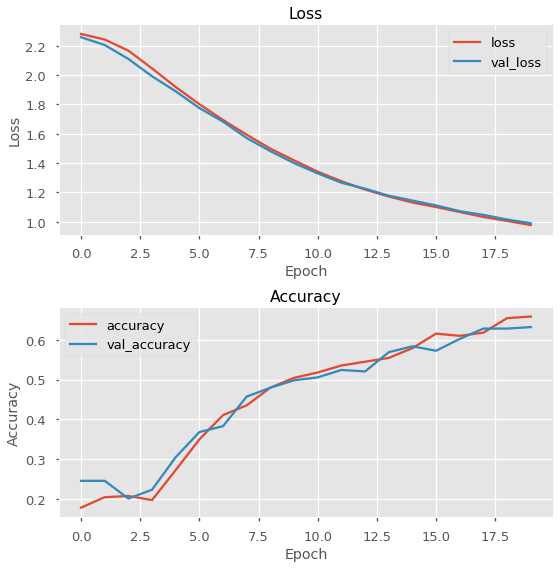

In [50]:
plot_history(history)

## Change Batch Size
By default, we use *mini-batch gradient descent*. We can change this by altering the `batch_size` parameter.

### Mini-Batch

In [51]:
model = Sequential()
model.add(layers.Dense(units=4, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dense(units=6, activation='relu'))
model.add(layers.Dense(units=10, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [52]:
X_train.shape[0]

1259

In [55]:
# Full-batch.
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=30,
    batch_size=X_train.shape[0]
    )

Epoch 1/30
1/1 [==============================] - 0s 90ms/step - loss: 2.2910 - accuracy: 0.0921 - val_loss: 2.2934 - val_accuracy: 0.0743
Epoch 2/30
1/1 [==============================] - 0s 40ms/step - loss: 2.2888 - accuracy: 0.0929 - val_loss: 2.2911 - val_accuracy: 0.0743
Epoch 3/30
1/1 [==============================] - 0s 41ms/step - loss: 2.2866 - accuracy: 0.0929 - val_loss: 2.2888 - val_accuracy: 0.0743
Epoch 4/30
1/1 [==============================] - 0s 44ms/step - loss: 2.2846 - accuracy: 0.0929 - val_loss: 2.2867 - val_accuracy: 0.0781
Epoch 5/30
1/1 [==============================] - 0s 42ms/step - loss: 2.2828 - accuracy: 0.0929 - val_loss: 2.2848 - val_accuracy: 0.0781
Epoch 6/30
1/1 [==============================] - 0s 40ms/step - loss: 2.2810 - accuracy: 0.0913 - val_loss: 2.2830 - val_accuracy: 0.0781
Epoch 7/30
1/1 [==============================] - 0s 38ms/step - loss: 2.2793 - accuracy: 0.0921 - val_loss: 2.2812 - val_accuracy: 0.0743
Epoch 8/30
1/1 [===========

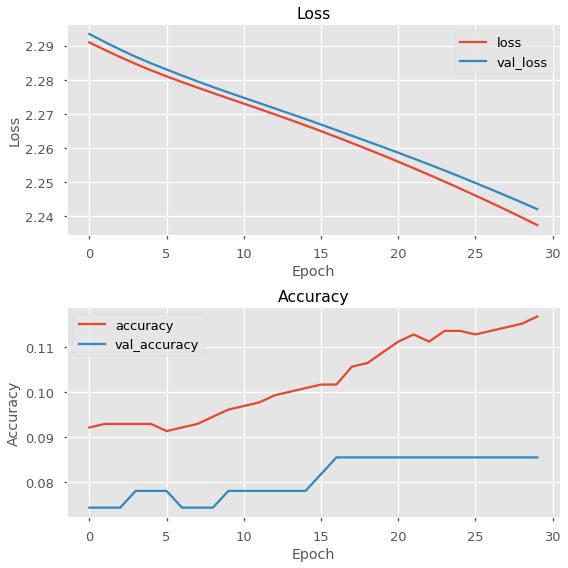

In [56]:
plot_history(history)

### Stochastic Gradient Descent

In [57]:
model = Sequential()
model.add(layers.Dense(units=4, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dense(units=6, activation='relu'))
model.add(layers.Dense(units=10, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))

model.compile(
    optimizer="RMSProp", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [58]:
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=10,
    batch_size=1
    )

Epoch 1/10
1259/1259 [==============================] - 2s 964us/step - loss: 2.2518 - accuracy: 0.1881 - val_loss: 1.9617 - val_accuracy: 0.3234
Epoch 2/10
1259/1259 [==============================] - 1s 814us/step - loss: 1.7738 - accuracy: 0.3628 - val_loss: 1.4388 - val_accuracy: 0.4015
Epoch 3/10
1259/1259 [==============================] - 1s 836us/step - loss: 1.3426 - accuracy: 0.4641 - val_loss: 1.2113 - val_accuracy: 0.5465
Epoch 4/10
1259/1259 [==============================] - 1s 858us/step - loss: 1.0880 - accuracy: 0.5939 - val_loss: 1.0640 - val_accuracy: 0.5836
Epoch 5/10
1259/1259 [==============================] - 1s 810us/step - loss: 1.0031 - accuracy: 0.6157 - val_loss: 0.9900 - val_accuracy: 0.6468
Epoch 6/10
1259/1259 [==============================] - 1s 776us/step - loss: 0.9583 - accuracy: 0.6369 - val_loss: 0.9779 - val_accuracy: 0.6357
Epoch 7/10
1259/1259 [==============================] - 1s 769us/step - loss: 0.9214 - accuracy: 0.6216 - val_loss: 0.9549 -

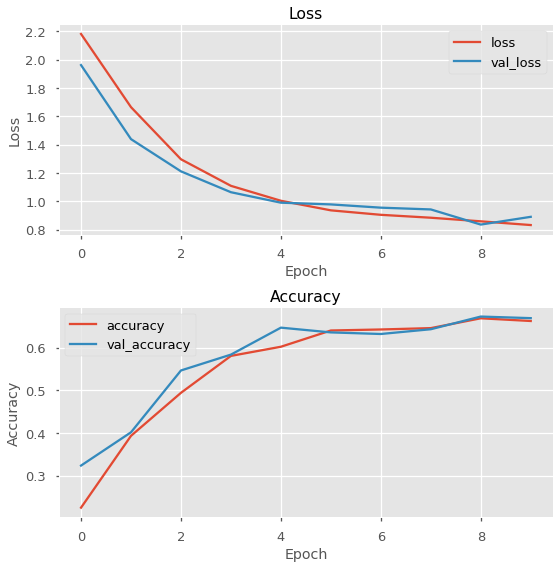

In [59]:
plot_history(history)

<a id='tuning'></a>
# Baseline Model - Before Tuning

In [60]:
model = Sequential()
model.add(layers.Dense(units=64, activation='relu', 
                       input_dim=X_train.shape[1]))

model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=8, activation='relu'))

model.add(layers.Dense(units=10, activation='softmax'))

model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 10)                90        
Total params: 6,994
Trainable params: 6,994
Non-trainable params: 0
_________________________________________________________________


In [61]:
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=50,
    batch_size=32
    )

Epoch 1/50
40/40 [==============================] - 1s 5ms/step - loss: 2.2719 - accuracy: 0.1598 - val_loss: 2.1357 - val_accuracy: 0.2825
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 2.1027 - accuracy: 0.2415 - val_loss: 1.8301 - val_accuracy: 0.3680
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 1.7602 - accuracy: 0.4175 - val_loss: 1.3964 - val_accuracy: 0.5688
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 1.3503 - accuracy: 0.5992 - val_loss: 1.0876 - val_accuracy: 0.6952
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 1.0682 - accuracy: 0.6881 - val_loss: 0.8503 - val_accuracy: 0.7472
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 0.8002 - accuracy: 0.7663 - val_loss: 0.6693 - val_accuracy: 0.7955
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6174 - accuracy: 0.8153 - val_loss: 0.5708 - val_accuracy: 0.7993
Epoch 8/50
40/40 [==

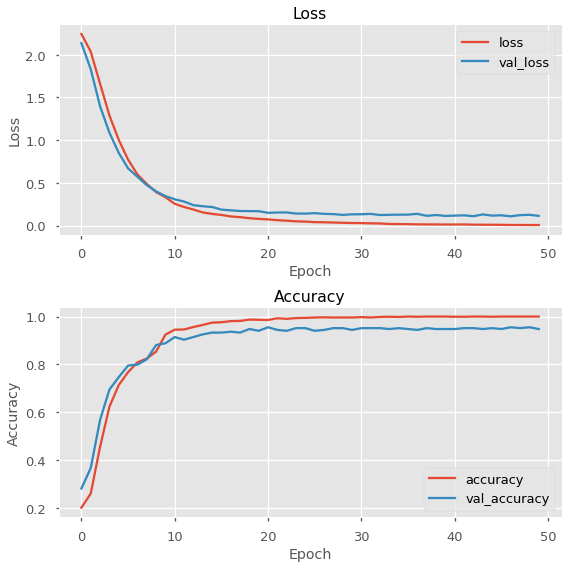

In [62]:
plot_history(history)

# Regularization

In [63]:
from tensorflow.keras import regularizers

In [64]:
# Adding a regularizer to the first hidden layer.
model = Sequential()
model.add(layers.Dense(units=64, activation='relu', 
                       input_dim=X_train.shape[1]))

model.add(layers.Dense(units=32, activation='relu', 
                       kernel_regularizer=regularizers.l2())) # L2 Regularizer
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=8, activation='relu'))

model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_24 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_26 (Dense)             (None, 10)                90        
Total params: 6,994
Trainable params: 6,994
Non-trainable params: 0
_________________________________________________________________


In [65]:
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=50,
    batch_size=32
    )

Epoch 1/50
40/40 [==============================] - 1s 5ms/step - loss: 2.6622 - accuracy: 0.1092 - val_loss: 2.4076 - val_accuracy: 0.2045
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 2.3587 - accuracy: 0.2048 - val_loss: 2.0728 - val_accuracy: 0.3234
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 2.0318 - accuracy: 0.3278 - val_loss: 1.7359 - val_accuracy: 0.5093
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 1.7147 - accuracy: 0.5469 - val_loss: 1.4385 - val_accuracy: 0.5985
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 1.4287 - accuracy: 0.6377 - val_loss: 1.1800 - val_accuracy: 0.7100
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 1.1541 - accuracy: 0.7228 - val_loss: 0.9856 - val_accuracy: 0.7398
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 0.9597 - accuracy: 0.7774 - val_loss: 0.9042 - val_accuracy: 0.7509
Epoch 8/50
40/40 [==

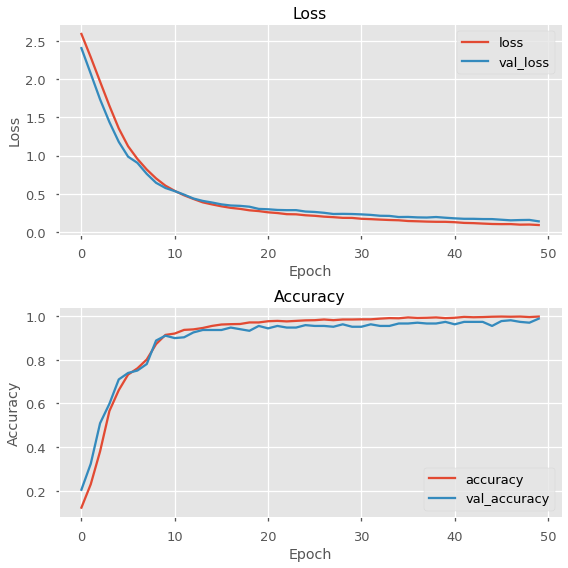

In [66]:
plot_history(history)

In [67]:
# Adding a regularizer to the each layer.
model = Sequential()
model.add(layers.Dense(units=64, activation='relu', 
                       input_dim=X_train.shape[1]))
model.add(layers.Dense(units=32, activation='relu', 
                       kernel_regularizer=regularizers.l2()))
model.add(layers.Dense(units=16, activation='relu',
                       kernel_regularizer=regularizers.l2()))
model.add(layers.Dense(units=8, activation='relu',
                       kernel_regularizer=regularizers.l2()))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=50,
    batch_size=32
    )

Epoch 1/50
40/40 [==============================] - 1s 6ms/step - loss: 2.9587 - accuracy: 0.1505 - val_loss: 2.7499 - val_accuracy: 0.1970
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 2.6716 - accuracy: 0.1963 - val_loss: 2.4869 - val_accuracy: 0.2119
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 2.3896 - accuracy: 0.2523 - val_loss: 2.2255 - val_accuracy: 0.2528
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 2.1154 - accuracy: 0.3156 - val_loss: 2.0120 - val_accuracy: 0.3309
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 1.9312 - accuracy: 0.4065 - val_loss: 1.8593 - val_accuracy: 0.3643
Epoch 6/50
40/40 [==============================] - 0s 4ms/step - loss: 1.7773 - accuracy: 0.4547 - val_loss: 1.7330 - val_accuracy: 0.4275
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 1.6824 - accuracy: 0.4817 - val_loss: 1.6380 - val_accuracy: 0.4944
Epoch 8/50
40/40 [==

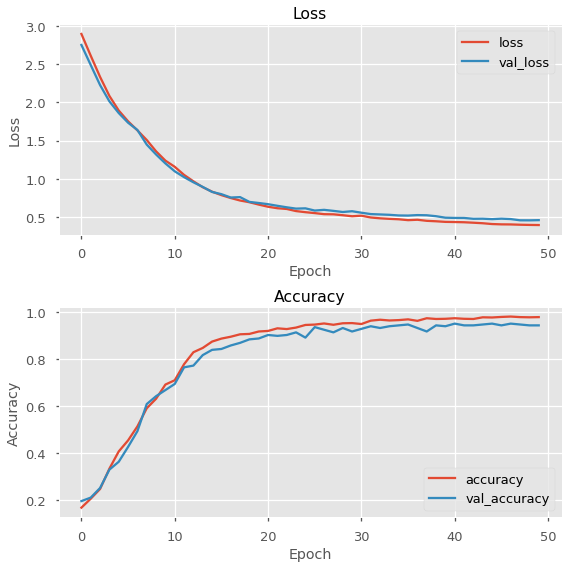

In [68]:
plot_history(history)

# Dropout
<img src='./images/drop_out.png'>

- *Adding dropout will randomly deactivate nodes during training in an attempt to strengthen and clarify the remaining active nodes.*

In [69]:
# Adding dropouts to each layer.
model = Sequential()
model.add(layers.Dense(units=64, activation='relu', 
                       input_dim=X_train.shape[1]))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(units=8, activation='relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=50,
    batch_size=32
    )

Epoch 1/50
40/40 [==============================] - 1s 6ms/step - loss: 2.3473 - accuracy: 0.0896 - val_loss: 2.2997 - val_accuracy: 0.1152
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 2.2995 - accuracy: 0.1014 - val_loss: 2.2926 - val_accuracy: 0.2156
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 2.2801 - accuracy: 0.1333 - val_loss: 2.2627 - val_accuracy: 0.3086
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 2.2410 - accuracy: 0.1649 - val_loss: 2.1663 - val_accuracy: 0.4052
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 2.1726 - accuracy: 0.2000 - val_loss: 2.0194 - val_accuracy: 0.4015
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 2.0918 - accuracy: 0.2076 - val_loss: 1.8896 - val_accuracy: 0.4461
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 1.9881 - accuracy: 0.2940 - val_loss: 1.6942 - val_accuracy: 0.4498
Epoch 8/50
40/40 [==

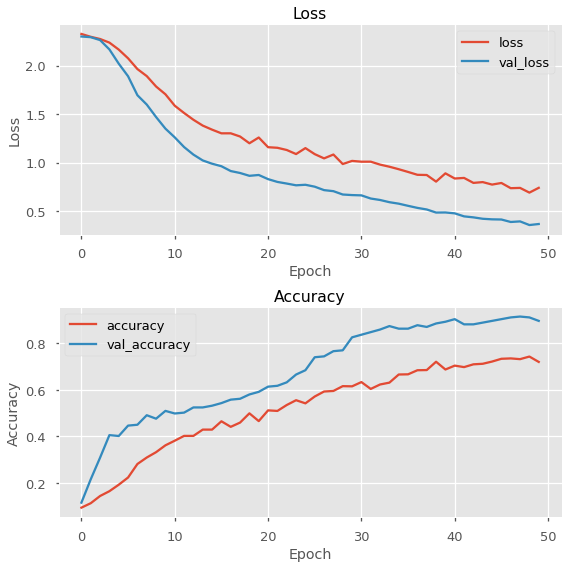

In [70]:
plot_history(history)

In [71]:
# Adding fewer dropouts to each layer.
model = Sequential()
model.add(layers.Dense(units=64, activation='relu', 
                       input_dim=X_train.shape[1]))
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(units=8, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=50,
    batch_size=32
    )

Epoch 1/50
40/40 [==============================] - 1s 6ms/step - loss: 2.2901 - accuracy: 0.1101 - val_loss: 2.1237 - val_accuracy: 0.2119
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 2.0708 - accuracy: 0.2429 - val_loss: 1.7453 - val_accuracy: 0.4126
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 1.7449 - accuracy: 0.3634 - val_loss: 1.3938 - val_accuracy: 0.6543
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 1.4713 - accuracy: 0.4900 - val_loss: 1.0710 - val_accuracy: 0.7361
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 1.1970 - accuracy: 0.6073 - val_loss: 0.8003 - val_accuracy: 0.8550
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 1.0380 - accuracy: 0.6727 - val_loss: 0.6483 - val_accuracy: 0.8810
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 0.9123 - accuracy: 0.7033 - val_loss: 0.5489 - val_accuracy: 0.9145
Epoch 8/50
40/40 [==

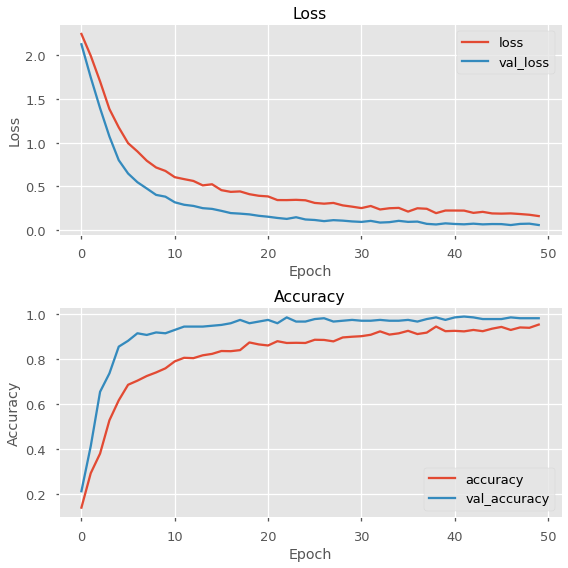

In [72]:
plot_history(history)

# Early Stopping
- *We can have the model stop training before the given number of epochs if it stops improving.*

In [73]:
from tensorflow.keras.callbacks import EarlyStopping

In [74]:
# Adding EarlyStopping.
model = Sequential()
model.add(layers.Dense(units=64, activation='relu', 
                       input_dim=X_train.shape[1]))

model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=8, activation='relu'))

model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=200,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True, verbose=1)]
    )

Epoch 1/200
40/40 [==============================] - 1s 5ms/step - loss: 2.2377 - accuracy: 0.1684 - val_loss: 1.9880 - val_accuracy: 0.3866
Epoch 2/200
40/40 [==============================] - 0s 2ms/step - loss: 1.8728 - accuracy: 0.4214 - val_loss: 1.4419 - val_accuracy: 0.5985
Epoch 3/200
40/40 [==============================] - 0s 2ms/step - loss: 1.2862 - accuracy: 0.6568 - val_loss: 0.8883 - val_accuracy: 0.7509
Epoch 4/200
40/40 [==============================] - 0s 2ms/step - loss: 0.8192 - accuracy: 0.7633 - val_loss: 0.5720 - val_accuracy: 0.8662
Epoch 5/200
40/40 [==============================] - 0s 2ms/step - loss: 0.5753 - accuracy: 0.8337 - val_loss: 0.4609 - val_accuracy: 0.8699
Epoch 6/200
40/40 [==============================] - 0s 2ms/step - loss: 0.4588 - accuracy: 0.8925 - val_loss: 0.3666 - val_accuracy: 0.9071
Epoch 7/200
40/40 [==============================] - 0s 2ms/step - loss: 0.3802 - accuracy: 0.9028 - val_loss: 0.3187 - val_accuracy: 0.9145
Epoch 8/200
4

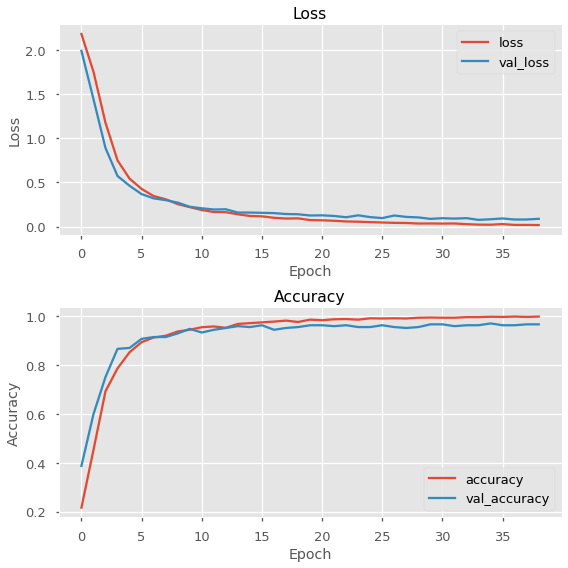

In [75]:
plot_history(history)